In [72]:
import torch
from torchvision import datasets, transforms
import numpy as np
import pickle
import matplotlib.pyplot as plt
import random
import torch.optim as optim
import time
import torch.utils.data
import os
from sklearn.model_selection import train_test_split
from torch.utils.data import Dataset, DataLoader
from PIL import Image

import pandas as pd



# Load CIFAR 10 Data


In [74]:


# Function to load a batch file and return a dictionary
def unpickle(file):
    with open(file, 'rb') as fo:
        dict = pickle.load(fo, encoding='bytes')
    return dict

# Load dataset, combine batches, split, and visualize images
def load_and_prepare_data():
    # Load and combine the training batches
    data_batches, label_batches = [], []
    for i in range(1, 6):
        batch = unpickle(f'data/KaggleData/cifar-10-python/cifar-10-batches-py/data_batch_{i}')
        data_batches.append(batch[b'data'])
        label_batches.append(batch[b'labels'])
    X, y = np.concatenate(data_batches), np.concatenate(label_batches)
    
    # Split into training and validation sets (80-20 split)
    return train_test_split(X, y, test_size=0.2, random_state=42)

X_train, X_val, y_train, y_val = load_and_prepare_data()

# Custom Dataset class for CIFAR-10
class CIFAR10Dataset(Dataset):
    def __init__(self, data, labels, transform=None):
        self.data = data
        self.labels = labels
        self.transform = transform
        
    def __len__(self):
        return len(self.labels)
    
    def __getitem__(self, idx):
        image = self.data[idx].reshape(3, 32, 32).transpose(1, 2, 0)
        image = Image.fromarray(image.astype('uint8'), 'RGB')
        if self.transform:
            image = self.transform(image)
        return image, self.labels[idx]

# Define transformations
stats = ((0.4914, 0.4822, 0.4465), (0.2023, 0.1994, 0.2010)) 
transformations = {
    'train': transforms.Compose([
        transforms.RandomCrop(32, padding=4, padding_mode='reflect'), 
        transforms.RandomHorizontalFlip(), 
        transforms.ToTensor(), 
        transforms.Normalize(*stats,inplace=True)]),
    'valid': transforms.Compose([
        transforms.ToTensor(), 
        transforms.Normalize(*stats)])
}

# Create datasets and DataLoader instances
datasets = {
    'train': CIFAR10Dataset(X_train, y_train, transform=transformations['train']),
    'valid': CIFAR10Dataset(X_val, y_val, transform=transformations['valid'])
}
loaders = {
    'train': DataLoader(datasets['train'], batch_size=64, shuffle=True),
    'valid': DataLoader(datasets['valid'], batch_size=64, shuffle=False)
}

print('Amount of Train Data batches: ', len(loaders['train']))
print('Amount of Valid Data batches: ', len(loaders['valid']))

print('Amount of training images: ', len(X_train))
print('Amount of Validation images: ', len(X_val))


Amount of Train Data batches:  625
Amount of Valid Data batches:  157
Amount of training images:  40000
Amount of Validation images:  10000


Training Images:


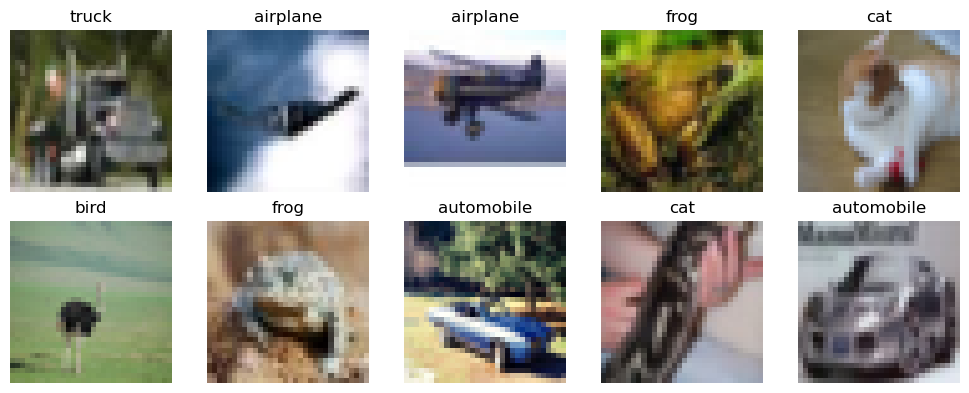

Validation Images:


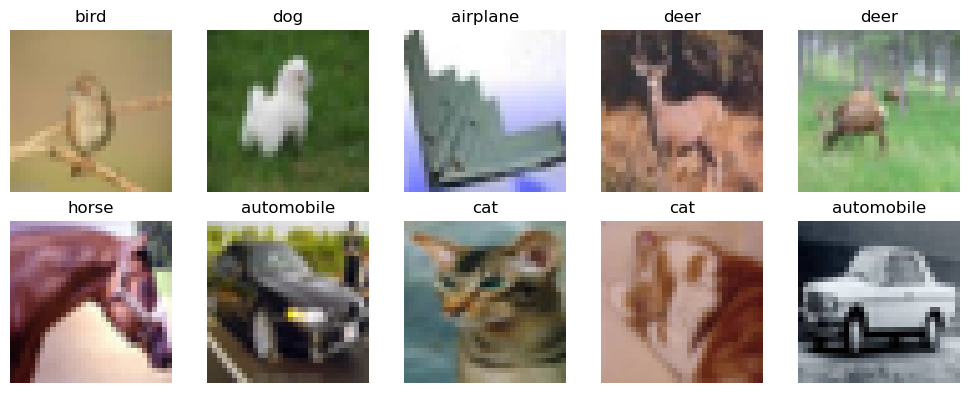

In [77]:
#visualize:
import matplotlib.pyplot as plt
import numpy as np
from torchvision.transforms import ToPILImage
from random import sample

# Define a function to show images in a grid
def show_images(images, labels, classes, rows=2, cols=5, scale=2):
    fig, axes = plt.subplots(rows, cols, figsize=(scale*cols, scale*rows))
    axes = axes.flatten()
    for img, label, ax in zip(images, labels, axes):
        img = img.reshape(3, 32, 32).transpose(1, 2, 0)  # Convert to HxWxC format
        if np.max(img) > 1:  # Assume the image is in the range [0, 255]
            img = img / 255.0
        ax.imshow(img)
        ax.axis('off')
        ax.set_title(classes[label])
    plt.tight_layout()
    plt.show()

# Classes in CIFAR-10
classes = ['airplane', 'automobile', 'bird', 'cat', 'deer',
           'dog', 'frog', 'horse', 'ship', 'truck']

# Randomly select 10 images and their labels from training set
indices_train = sample(range(len(X_train)), 10)
images_train = X_train[indices_train]
labels_train = y_train[indices_train]

# Randomly select 10 images and their labels from validation set
indices_val = sample(range(len(X_val)), 10)
images_val = X_val[indices_val]
labels_val = y_val[indices_val]

# Display training images
print("Training Images:")
show_images(images_train, labels_train, classes)

# Display validation images
print("Validation Images:")
show_images(images_val, labels_val, classes)



# Model

Constraints: 

- Resnet
- under 5 Mio Params 



In [75]:
import torch
import torch.nn as nn
import torch.nn.functional as F

class BasicBlock(nn.Module):
    expansion = 1

    def __init__(self, in_planes, planes, stride=1, dropout_rate=0.0):
        super(BasicBlock, self).__init__()
        self.dropout_rate = dropout_rate
        self.conv1 = nn.Conv2d(in_planes, planes, kernel_size=3, stride=stride, padding=1, bias=False)
        self.bn1 = nn.BatchNorm2d(planes)
        self.conv2 = nn.Conv2d(planes, planes, kernel_size=3, stride=1, padding=1, bias=False)
        self.bn2 = nn.BatchNorm2d(planes)

        self.shortcut = nn.Sequential()
        if stride != 1 or in_planes != self.expansion*planes:
            self.shortcut = nn.Sequential(
                nn.Conv2d(in_planes, self.expansion*planes, kernel_size=1, stride=stride, bias=False),
                nn.BatchNorm2d(self.expansion*planes)
            )
        self.dropout = nn.Dropout(dropout_rate) if dropout_rate > 0 else None

    def forward(self, x):
        out = F.relu(self.bn1(self.conv1(x)))
        if self.dropout:
            out = self.dropout(out)
        out = self.bn2(self.conv2(out))
        out += self.shortcut(x)
        out = F.relu(out)
        return out

class ResNet(nn.Module):
    def __init__(self, block, num_blocks, num_classes=10,dropout_rate=0.0):
        super(ResNet, self).__init__()
        self.in_planes = 64

        self.conv1 = nn.Conv2d(3, 64, kernel_size=3, stride=1, padding=1, bias=False)
        self.bn1 = nn.BatchNorm2d(64)
        self.layer1 = self._make_layer(block, 64, num_blocks[0], stride=1, dropout_rate=dropout_rate)
        self.layer2 = self._make_layer(block, 128, num_blocks[1], stride=2, dropout_rate=dropout_rate)
        self.layer3 = self._make_layer(block, 128, num_blocks[2], stride=2, dropout_rate=dropout_rate)
        self.layer4 = self._make_layer(block, 256, num_blocks[3], stride=2, dropout_rate=dropout_rate)
    
        self.linear = nn.Linear(256*block.expansion, num_classes)

    def _make_layer(self, block, planes, num_blocks, stride, dropout_rate=0.0):
        strides = [stride] + [1]*(num_blocks-1)
        layers = []
        for stride in strides:
            layers.append(block(self.in_planes, planes, stride, dropout_rate=dropout_rate))
            self.in_planes = planes * block.expansion
        return nn.Sequential(*layers)

    def forward(self, x):
        out = F.relu(self.bn1(self.conv1(x)))
        out = self.layer1(out)
        out = self.layer2(out)
        out = self.layer3(out)
        out = self.layer4(out)
        out = F.avg_pool2d(out, 4)
        out = out.view(out.size(0), -1)
        out = self.linear(out)
        return out

# Adjusting the number of blocks to reduce the total parameters
def ResNetModified(dropout_rate=0.0):
    return ResNet(BasicBlock, [2, 2, 2, 2], dropout_rate=dropout_rate)

def test():
    net = ResNetModified()
    y = net(torch.randn(1, 3, 32, 32))
    print(y.size())

test()

# Instantiate the model
model = ResNetModified(dropout_rate=0.25)
# Move the model to CUDA device if available
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
print(torch.cuda.get_device_name(0))
model.to(device)

torch.Size([1, 10])
NVIDIA GeForce RTX 4070


ResNet(
  (conv1): Conv2d(3, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
  (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (layer1): Sequential(
    (0): BasicBlock(
      (conv1): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
      (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (conv2): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
      (bn2): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (shortcut): Sequential()
      (dropout): Dropout(p=0.25, inplace=False)
    )
    (1): BasicBlock(
      (conv1): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
      (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (conv2): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
      (bn2): 

In [76]:
#Total Parameters in model
total_params = sum(p.numel() for p in model.parameters())
print(f"Total parameters: {total_params}")


Total parameters: 3385162


# Training

In [39]:
#Training Parameters

from torch.optim.lr_scheduler import ExponentialLR

criterion = nn.CrossEntropyLoss()
optimizer = optim.AdamW(model.parameters(), lr=0.001,weight_decay=0.001)
scheduler = ExponentialLR(optimizer, gamma=0.99) 
num_epochs = 40
model_path = 'best_model.pth'



Epoch: 1 [6400/40000 (16%)]  Loss: 1.8471
Epoch: 1 [12800/40000 (32%)]  Loss: 1.6002
Epoch: 1 [19200/40000 (48%)]  Loss: 1.4591
Epoch: 1 [25600/40000 (64%)]  Loss: 1.3561
Epoch: 1 [32000/40000 (80%)]  Loss: 1.3222
Epoch: 1 [38400/40000 (96%)]  Loss: 1.2529

Epoch 1: Avg. Training Loss: 1.4626, Avg. Valid Loss: 1.1779, Valid Accuracy: 57.39%

Saved best model
Epoch: 2 [6400/40000 (16%)]  Loss: 1.1548
Epoch: 2 [12800/40000 (32%)]  Loss: 1.1214
Epoch: 2 [19200/40000 (48%)]  Loss: 1.0780
Epoch: 2 [25600/40000 (64%)]  Loss: 1.0405
Epoch: 2 [32000/40000 (80%)]  Loss: 1.0271
Epoch: 2 [38400/40000 (96%)]  Loss: 0.9765

Epoch 2: Avg. Training Loss: 1.0621, Avg. Valid Loss: 1.0676, Valid Accuracy: 61.80%

Saved best model
Epoch: 3 [6400/40000 (16%)]  Loss: 0.9495
Epoch: 3 [12800/40000 (32%)]  Loss: 0.9211
Epoch: 3 [19200/40000 (48%)]  Loss: 0.9166
Epoch: 3 [25600/40000 (64%)]  Loss: 0.8849
Epoch: 3 [32000/40000 (80%)]  Loss: 0.8205
Epoch: 3 [38400/40000 (96%)]  Loss: 0.8351

Epoch 3: Avg. Traini

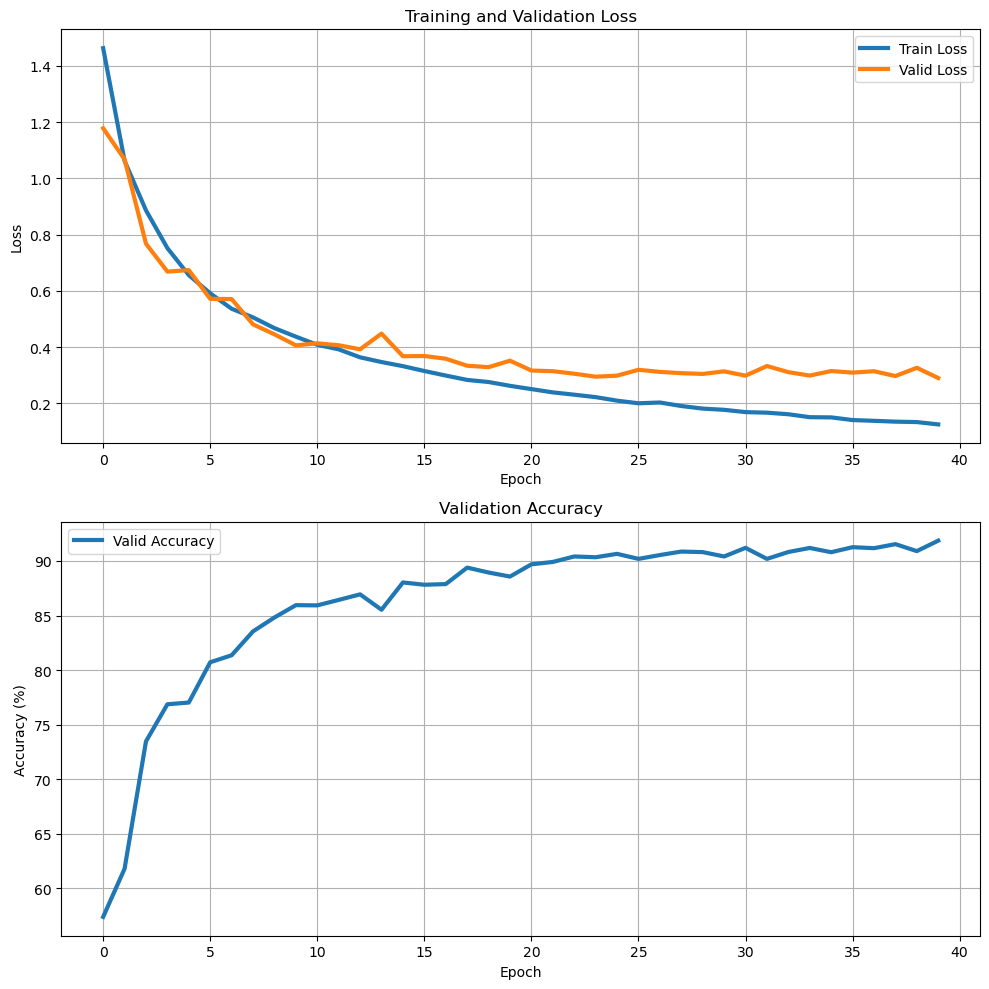

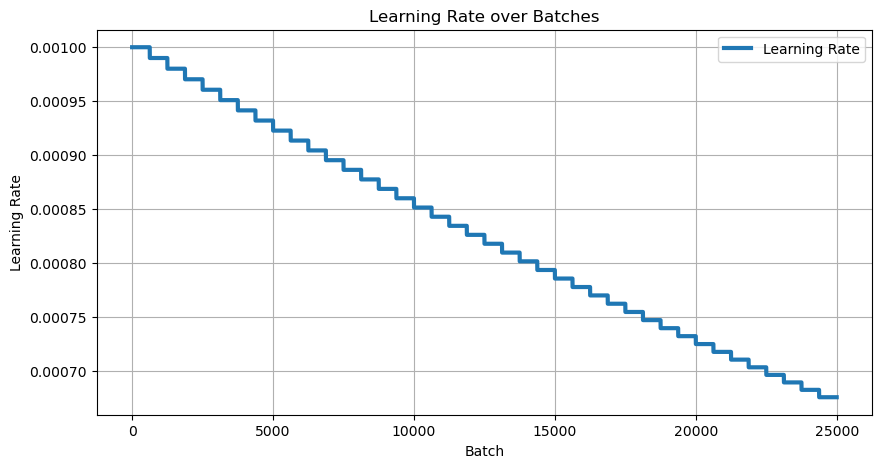

In [42]:
import time
import torch
import matplotlib.pyplot as plt

# Assuming device, model, criterion, optimizer, scheduler, num_epochs, and model_path are already defined

# Resetting histories in case this block is run multiple times
train_loss_history, valid_loss_history, valid_accuracy_history, learning_rate_history = [], [], [], []

best_accuracy = 0.0
start_time = time.time()

for epoch in range(1, num_epochs + 1):
    model.train()
    running_loss, total_train_loss, num_batches = 0.0, 0.0, 0
    
    for i, (inputs, labels) in enumerate(loaders['train']):
        inputs, labels = inputs.to(device), labels.to(device)
        labels = labels.long()  # Ensure labels are of the correct dtype for the loss calculation
        optimizer.zero_grad()
        outputs = model(inputs)
        loss = criterion(outputs, labels)
        loss.backward()
        torch.nn.utils.clip_grad_norm_(model.parameters(), max_norm=1.0)
        optimizer.step()
        
        running_loss += loss.item()
        total_train_loss += loss.item()
        num_batches += 1
        
        # Record the learning rate
        learning_rate_history.append(optimizer.param_groups[0]['lr'])
        
        if (i+1) % 100 == 0:
            print(f"Epoch: {epoch} [{i * len(inputs) + len(inputs)}/{len(loaders['train'].dataset)} "
                  f"({100. * (i + 1) / len(loaders['train']):.0f}%)]  Loss: {running_loss / 100:.4f}")
            running_loss = 0.0

    scheduler.step()  # Update the learning rate
    avg_train_loss = total_train_loss / num_batches
    train_loss_history.append(avg_train_loss)
    
    # Validation phase
    model.eval()
    total_valid_loss, correct, num_valid_batches = 0.0, 0, 0
    
    with torch.no_grad():
        for inputs, labels in loaders['valid']:
            inputs, labels = inputs.to(device), labels.to(device)
            labels = labels.long()  # Ensure labels are of the correct dtype for the loss calculation
            outputs = model(inputs)
            loss = criterion(outputs, labels)
            total_valid_loss += loss.item()
            pred = outputs.argmax(dim=1, keepdim=True)
            correct += pred.eq(labels.view_as(pred)).sum().item()
            num_valid_batches += 1

    avg_valid_loss = total_valid_loss / num_valid_batches
    valid_accuracy = 100. * correct / len(datasets['valid'])
    
    valid_loss_history.append(avg_valid_loss)
    valid_accuracy_history.append(valid_accuracy)
    
    print(f"\nEpoch {epoch}: Avg. Training Loss: {avg_train_loss:.4f}, Avg. Valid Loss: {avg_valid_loss:.4f}, "
          f"Valid Accuracy: {valid_accuracy:.2f}%\n")
    
    if valid_accuracy > best_accuracy:
        best_accuracy = valid_accuracy
        torch.save(model.state_dict(), model_path)
        print("Saved best model")

execution_time = time.time() - start_time
print(f"Execution time: {execution_time:.2f} seconds")

# After training, load the best model and evaluate
model.load_state_dict(torch.load(model_path))
model.eval()

# Plot the training and validation loss and accuracy
fig, axs = plt.subplots(2, 1, figsize=(10, 10))
axs[0].plot(train_loss_history, '-', linewidth=3, label='Train Loss')
axs[0].plot(valid_loss_history, '-', linewidth=3, label='Valid Loss')
axs[0].legend()
axs[0].set_title('Training and Validation Loss')
axs[0].set_xlabel('Epoch')
axs[0].set_ylabel('Loss')
axs[0].grid(True)

axs[1].plot(valid_accuracy_history, '-', linewidth=3, label='Valid Accuracy')
axs[1].legend()
axs[1].set_title('Validation Accuracy')
axs[1].set_xlabel('Epoch')
axs[1].set_ylabel('Accuracy (%)')
axs[1].grid(True)
plt.tight_layout()
plt.show()

# Plot learning rate over batches
plt.figure(figsize=(10, 5))
plt.plot(learning_rate_history, '-', linewidth=3, label='Learning Rate')
plt.legend()
plt.title('Learning Rate over Batches')
plt.xlabel('Batch')
plt.ylabel('Learning Rate')
plt.grid(True)
plt.show()


# Testing

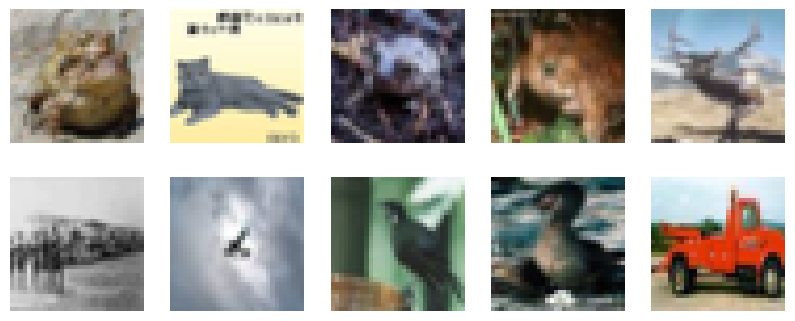

In [108]:
import numpy as np
import matplotlib.pyplot as plt

def unpickle(file):
    import pickle
    with open(file, 'rb') as fo:
        dict = pickle.load(fo, encoding='bytes')
    return dict

test_data_dict = unpickle('./data/cifar_test_nolabels.pkl')
test_images = test_data_dict[b'data']
test_images = test_images.reshape(-1, 3, 32, 32)

# Modified function to show random images
def show_original_random_images(images, rows=2, cols=5):
    fig, axes = plt.subplots(rows, cols, figsize=(cols * 2, rows * 2))
    indices = np.random.choice(len(images), rows*cols, replace=False)  # Select random indices
    for i, ax in enumerate(axes.flat):
        # Use the random index to select an image
        img = images[indices[i]].transpose(1, 2, 0)
        ax.imshow(img.astype('uint8'))
        ax.axis('off')
    plt.show()

# Show 10 random original images
show_original_random_images(test_images, rows=2, cols=5)


In [ ]:
# Convert test_images to a float tensor
test_images = torch.from_numpy(test_images).float()

# If the pixel values are in [0,255], scale them to [0,1]
if test_images.max() > 1.0:
    test_images /= 255.0

# Permute the images to [N, C, H, W] format
test_images = test_images.permute(0, 1, 2, 3)


# # Normalization stats
# mean = [0.4914, 0.4822, 0.4465]
# std = [0.2023, 0.1994, 0.2010]

# Define the normalization transform
normalize = transforms.Normalize(*stats)

# Normalize the images
normalized_images = torch.stack([normalize(img) for img in test_images])

# Make sure your model is on the right device
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
model.to(device)

# Now, ensure your input data is also sent to the same device
normalized_images = normalized_images.to(device)

model.eval()  # Set the model to evaluation mode

predictions = []
with torch.no_grad():  # No need to track gradients
    for img in normalized_images:
        img = img.unsqueeze(0).to(device)  # Add batch dimension and ensure the tensor is on the right device
        output = model(img)  # Process each image individually
        pred = output.argmax(dim=1)  # Get the index of the max log-probability
        predictions.append(pred.item())
print(len(predictions))

# Create a DataFrame with the ID and predicted Labels
submission_df = pd.DataFrame({
    'ID': list(range(len(predictions))),
    'Labels': predictions
})

# Define the submission CSV file path
submission_csv_path = 'submission.csv'
# Save the DataFrame to a CSV file, without the index
submission_df.to_csv(submission_csv_path, index=False)

# Returning the path to the saved CSV file
submission_csv_path

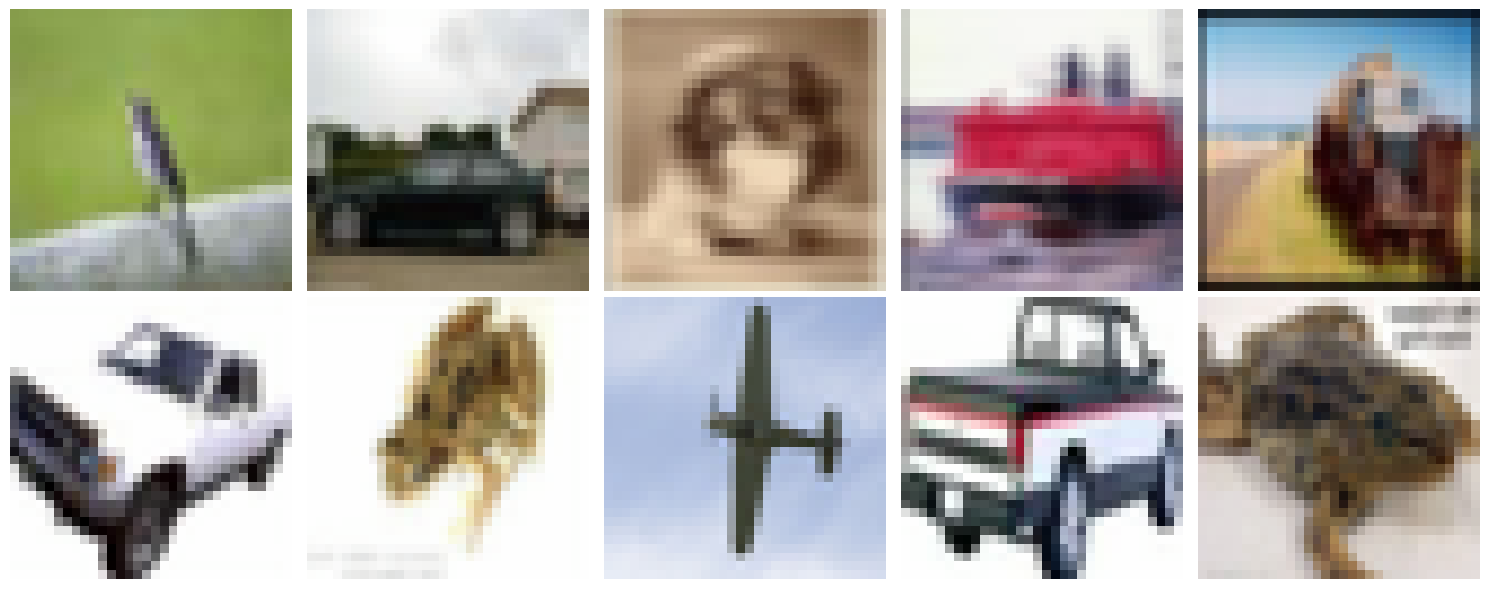

In [98]:
import matplotlib.pyplot as plt
import numpy as np

# Define mean and std
mean = np.array([0.4914, 0.4822, 0.4465])
std = np.array([0.2023, 0.1994, 0.2010])
import matplotlib.pyplot as plt
import numpy as np
from random import sample

def imshow(img):
    """Apply inverse normalization and plot the image"""
    img = img * std[:, None, None] + mean[:, None, None]  # Unnormalize
    img = np.clip(img, 0, 1)  # Clip values to [0,1]
    plt.imshow(np.transpose(img, (1, 2, 0)))  # Convert from Tensor image

def show_random_images(images, num_images=10):
    """Show a sample of random images"""
    plt.figure(figsize=(15, 6))
    for i, index in enumerate(sample(range(len(images)), num_images), start=1):
        img = images[index]  # Directly use the NumPy array
        plt.subplot(2, 5, i)  # Plotting on a grid of 2x5
        imshow(img)
        plt.axis('off')
    plt.tight_layout()
    plt.show()

# Assuming normalized_images is a batch of images normalized and on the device
# Convert the normalized images back to numpy for visualization
# Make sure to detach them from GPU, convert to cpu, and then convert to numpy
images_numpy = normalized_images.cpu().detach().numpy()

# Now, display 10 random images from the test dataset
show_random_images(images_numpy, num_images=10)


# #-=====
# def imshow(img):
#     """Apply inverse normalization and plot the image"""
#     img = img * std[:, None, None] + mean[:, None, None]  # Unnormalize
#     img = np.clip(img, 0, 1)  # Clip values to [0,1]
#     plt.imshow(np.transpose(img, (1, 2, 0)))  # Convert from Tensor image

# def show_random_images(images, num_images=10):
#     """Show a sample of random images"""
#     plt.figure(figsize=(15, 6))
#     for i, index in enumerate(sample(range(len(images)), num_images), start=1):
#         img = images[index]  # Directly use the NumPy array
#         plt.subplot(2, 5, i)  # Plotting on a grid of 2x5
#         imshow(img)
#         plt.axis('off')
#     plt.tight_layout()
#     plt.show()

# # Assuming images_numpy is a batch of normalized images in NumPy format
# # Now, display 10 random images from the test dataset
# show_random_images(images_numpy, num_images=10)
